# 곡 추천 시스템 구축

### Import modules

In [23]:
%matplotlib inline

import pandas
from sklearn.model_selection import train_test_split
import numpy as np
import time
from sklearn.externals import joblib
import Recommenders as Recommenders
import Evaluation as Evaluation

### Load songdata

In [11]:
triplets_file = 'https://static.turi.com/datasets/millionsong/10000.txt'
songs_metadata_file = 'https://static.turi.com/datasets/millionsong/song_data.csv'

song_df_1 = pandas.read_csv(triplets_file, header=None, sep='\t')
song_df_1.columns = ['user_id', 'song_id', 'liseten_count']

# load song's metadata
song_df_2 = pandas.read_csv(songs_metadata_file)

# merge 2 dataframe
song_df = pandas.merge(song_df_1, song_df_2.drop_duplicates(['song_id']), on="song_id" , how="left")

### Create subset of the dataset

In [13]:
song_df = song_df.head(10000)

#Merge sonf title and artis_name columns to make a germed column
song_df['song'] = song_df['title'].map(str) + "-" + song_df['artist_name']

In [15]:
print(song_df.head())

                                    user_id             song_id  \
0  b80344d063b5ccb3212f76538f3d9e43d87dca9e  SOAKIMP12A8C130995   
1  b80344d063b5ccb3212f76538f3d9e43d87dca9e  SOBBMDR12A8C13253B   
2  b80344d063b5ccb3212f76538f3d9e43d87dca9e  SOBXHDL12A81C204C0   
3  b80344d063b5ccb3212f76538f3d9e43d87dca9e  SOBYHAJ12A6701BF1D   
4  b80344d063b5ccb3212f76538f3d9e43d87dca9e  SODACBL12A8C13C273   

   liseten_count            title                        release  \
0              1         The Cove             Thicker Than Water   
1              2  Entre Dos Aguas            Flamenco Para Niños   
2              1         Stronger                     Graduation   
3              1   Constellations              In Between Dreams   
4              1     Learn To Fly  There Is Nothing Left To Lose   

     artist_name  year                           song  
0   Jack Johnson     0          The Cove-Jack Johnson  
1  Paco De Lucia  1976  Entre Dos Aguas-Paco De Lucia  
2     Kanye West  20

### Showing the most popular songs in the dataset

In [17]:
song_grouped = song_df.groupby(['song']).agg({'liseten_count': 'count'}).reset_index()
grouped_sum = song_grouped['liseten_count'].sum()
song_grouped['percentage'] = song_grouped['liseten_count'].div(grouped_sum) * 100
song_grouped.sort_values(['liseten_count', 'song'], ascending = [0,1])

,song,liseten_count,percentage
3660,Sehr kosmisch-Harmonia,45,0.45
4678,Undo-Björk,32,0.32
5105,You're The One-Dwight Yoakam,32,0.32
1071,Dog Days Are Over (Radio Edit)-Florence + The ...,28,0.28
3655,Secrets-OneRepublic,28,0.28
4378,The Scientist-Coldplay,27,0.27
4712,Use Somebody-Kings Of Leon,27,0.27
3476,Revelry-Kings Of Leon,26,0.26
1387,Fireflies-Charttraxx Karaoke,24,0.24
1862,Horn Concerto No. 4 in E flat K495: II. Romanc...,23,0.23


### Count number of unique users in the dataset

In [21]:
users = song_df['user_id'].unique()
print(len(users))
songs = song_df['song'].unique()
print(len(songs))

365
5151


### Quiz1. Count the number of unique songs in the dataset

#### Create a song recommender

In [22]:
train_data, test_data = train_test_split(song_df, test_size = 0.20, random_state = 0)
print(train_data.head(5))

                                       user_id             song_id  \
7389  94d5bdc37683950e90c56c9b32721edb5d347600  SOXNZOW12AB017F756   
9275  1012ecfd277b96487ed8357d02fa8326b13696a5  SOXHYVQ12AB0187949   
2995  15415fa2745b344bce958967c346f2a89f792f63  SOOSZAZ12A6D4FADF8   
5316  ffadf9297a99945c0513cd87939d91d8b602936b  SOWDJEJ12A8C1339FE   
356   5a905f000fc1ff3df7ca807d57edb608863db05d  SOAMPRJ12A8AE45F38   

      liseten_count                 title  \
7389              2      Half Of My Heart   
9275              1  The Beautiful People   
2995              1     Sanctify Yourself   
5316              4     Heart Cooks Brain   
356              20                 Rorol   

                                                release      artist_name  \
7389                                     Battle Studies       John Mayer   
9275             Antichrist Superstar (Ecopac Explicit)   Marilyn Manson   
2995                             Glittering Prize 81/92     Simple Minds   
5316

### Simple popularity-based recommender class (Can be used as a black box)

In [24]:
pm = Recommenders.popularity_recommender_py()
pm.create(train_data, 'user_id', 'song')

In [25]:
user_id = users[5]
pm.recommend(user_id)

,user_id,song,score,Rank
3194,4bd88bfb25263a75bbdd467e74018f4ae570e5df,Sehr kosmisch-Harmonia,37,1.0
4083,4bd88bfb25263a75bbdd467e74018f4ae570e5df,Undo-Björk,27,2.0
931,4bd88bfb25263a75bbdd467e74018f4ae570e5df,Dog Days Are Over (Radio Edit)-Florence + The ...,24,3.0
4443,4bd88bfb25263a75bbdd467e74018f4ae570e5df,You're The One-Dwight Yoakam,24,4.0
3034,4bd88bfb25263a75bbdd467e74018f4ae570e5df,Revelry-Kings Of Leon,21,5.0
3189,4bd88bfb25263a75bbdd467e74018f4ae570e5df,Secrets-OneRepublic,21,6.0
4112,4bd88bfb25263a75bbdd467e74018f4ae570e5df,Use Somebody-Kings Of Leon,21,7.0
1207,4bd88bfb25263a75bbdd467e74018f4ae570e5df,Fireflies-Charttraxx Karaoke,20,8.0
1577,4bd88bfb25263a75bbdd467e74018f4ae570e5df,Hey_ Soul Sister-Train,19,9.0
1626,4bd88bfb25263a75bbdd467e74018f4ae570e5df,Horn Concerto No. 4 in E flat K495: II. Romanc...,19,10.0


In [26]:
user_id = users[8]
pm.recommend(user_id)

,user_id,song,score,Rank
3194,9bb911319fbc04f01755814cb5edb21df3d1a336,Sehr kosmisch-Harmonia,37,1.0
4083,9bb911319fbc04f01755814cb5edb21df3d1a336,Undo-Björk,27,2.0
931,9bb911319fbc04f01755814cb5edb21df3d1a336,Dog Days Are Over (Radio Edit)-Florence + The ...,24,3.0
4443,9bb911319fbc04f01755814cb5edb21df3d1a336,You're The One-Dwight Yoakam,24,4.0
3034,9bb911319fbc04f01755814cb5edb21df3d1a336,Revelry-Kings Of Leon,21,5.0
3189,9bb911319fbc04f01755814cb5edb21df3d1a336,Secrets-OneRepublic,21,6.0
4112,9bb911319fbc04f01755814cb5edb21df3d1a336,Use Somebody-Kings Of Leon,21,7.0
1207,9bb911319fbc04f01755814cb5edb21df3d1a336,Fireflies-Charttraxx Karaoke,20,8.0
1577,9bb911319fbc04f01755814cb5edb21df3d1a336,Hey_ Soul Sister-Train,19,9.0
1626,9bb911319fbc04f01755814cb5edb21df3d1a336,Horn Concerto No. 4 in E flat K495: II. Romanc...,19,10.0


### Class for an item similarity based personalized recommender system(Can be used as a black box)

In [27]:
is_model = Recommenders.item_similarity_recommender_py()
is_model.create(train_data, 'user_id', 'song')

In [28]:
# print traindata
user_id = users[5]
user_items = is_model.get_user_items(user_id)
print("------------------------------------------------------------------------------------")
print("Training data songs for the user userid: %s:" % user_id)
print("------------------------------------------------------------------------------------")
for user_item in user_items:
    print(user_item)
print("----------------------------------------------------------------------")
print("Recommendation process going on:")
print("----------------------------------------------------------------------")

# predic model
is_model.recommend(user_id)

------------------------------------------------------------------------------------
Training data songs for the user userid: 4bd88bfb25263a75bbdd467e74018f4ae570e5df:
------------------------------------------------------------------------------------
Just Lose It-Eminem
Without Me-Eminem
16 Candles-The Crests
Speechless-Lady GaGa
Push It-Salt-N-Pepa
Ghosts 'n' Stuff (Original Instrumental Mix)-Deadmau5
Say My Name-Destiny's Child
My Dad's Gone Crazy-Eminem / Hailie Jade
The Real Slim Shady-Eminem
Somebody To Love-Justin Bieber
Forgive Me-Leona Lewis
Missing You-John Waite
Ya Nada Queda-Kudai
----------------------------------------------------------------------
Recommendation process going on:
----------------------------------------------------------------------
No. of unique songs for the user: 13
no. of unique songs in the training set: 4483
Non zero values in cooccurence_matrix :2097


,user_id,song,score,rank
0,4bd88bfb25263a75bbdd467e74018f4ae570e5df,Superman-Eminem / Dina Rae,0.088692,1
1,4bd88bfb25263a75bbdd467e74018f4ae570e5df,Mockingbird-Eminem,0.067663,2
2,4bd88bfb25263a75bbdd467e74018f4ae570e5df,I'm Back-Eminem,0.065385,3
3,4bd88bfb25263a75bbdd467e74018f4ae570e5df,U Smile-Justin Bieber,0.064525,4
4,4bd88bfb25263a75bbdd467e74018f4ae570e5df,Here Without You-3 Doors Down,0.062293,5
5,4bd88bfb25263a75bbdd467e74018f4ae570e5df,Hellbound-J-Black & Masta Ace,0.055769,6
6,4bd88bfb25263a75bbdd467e74018f4ae570e5df,The Seed (2.0)-The Roots / Cody Chestnutt,0.052564,7
7,4bd88bfb25263a75bbdd467e74018f4ae570e5df,I'm The One Who Understands (Edit Version)-War,0.052564,8
8,4bd88bfb25263a75bbdd467e74018f4ae570e5df,Falling-Iration,0.052564,9
9,4bd88bfb25263a75bbdd467e74018f4ae570e5df,Armed And Ready (2009 Digital Remaster)-The Mi...,0.052564,10


### Quiz3. User the personalized model to make recommendations for the following user id. (Note the difference in recommendations from the first user id.)

In [29]:
user_id = users[7]
#이곳에 코드 입력
user_items = is_model.get_user_items(user_id)
#
print("------------------------------------------------------------------------------------")
print("Training data songs for the user userid: %s:" % user_id)
print("------------------------------------------------------------------------------------")

for user_item in user_items:
    print(user_item)

print("----------------------------------------------------------------------")
print("Recommendation process going on:")
print("----------------------------------------------------------------------")

#개인화된 모델을 이용해 사용자에게 곡을 추천합니다.
is_model.recommend(user_id)


------------------------------------------------------------------------------------
Training data songs for the user userid: 9d6f0ead607ac2a6c2460e4d14fb439a146b7dec:
------------------------------------------------------------------------------------
Swallowed In The Sea-Coldplay
Life In Technicolor ii-Coldplay
Life In Technicolor-Coldplay
The Scientist-Coldplay
Trouble-Coldplay
Strawberry Swing-Coldplay
Lost!-Coldplay
Clocks-Coldplay
----------------------------------------------------------------------
Recommendation process going on:
----------------------------------------------------------------------
No. of unique songs for the user: 8
no. of unique songs in the training set: 4483
Non zero values in cooccurence_matrix :3429


,user_id,song,score,rank
0,9d6f0ead607ac2a6c2460e4d14fb439a146b7dec,She Just Likes To Fight-Four Tet,0.281579,1
1,9d6f0ead607ac2a6c2460e4d14fb439a146b7dec,Warning Sign-Coldplay,0.281579,2
2,9d6f0ead607ac2a6c2460e4d14fb439a146b7dec,We Never Change-Coldplay,0.281579,3
3,9d6f0ead607ac2a6c2460e4d14fb439a146b7dec,Puppetmad-Puppetmastaz,0.281579,4
4,9d6f0ead607ac2a6c2460e4d14fb439a146b7dec,God Put A Smile Upon Your Face-Coldplay,0.281579,5
5,9d6f0ead607ac2a6c2460e4d14fb439a146b7dec,Susie Q-Creedence Clearwater Revival,0.281579,6
6,9d6f0ead607ac2a6c2460e4d14fb439a146b7dec,The Joker-Fatboy Slim,0.281579,7
7,9d6f0ead607ac2a6c2460e4d14fb439a146b7dec,Korg Rhythm Afro-Holy Fuck,0.281579,8
8,9d6f0ead607ac2a6c2460e4d14fb439a146b7dec,This Unfolds-Four Tet,0.281579,9
9,9d6f0ead607ac2a6c2460e4d14fb439a146b7dec,high fives-Four Tet,0.281579,10


## 모델간의 정량적 비교

In [32]:
start = time.time()
# 정밀도-재현율 계산에 사용될 사용자의 비율을 정의한다.
user_sample = 0.05
# 정밀도-재현율 계산 클래스를 인스턴스화한다.
pr = Evaluation.precision_recall_calculator(test_data,train_data, pm, is_model)
# 정밀도와 재현율을 계산할 메소드를 불러온다
(pm_avg_precision_list, pm_avg_recall_list, ism_avg_precision_list, ism_avg_recall_list) = pr.calculate_measures(user_sample)
end = time.time()
print(end - start)

Length of user_test_and_training:319
Length of user sample:15
Getting recommendations for user:6ac64072cb8f308f36c64cc4aafb6021fef70476
No. of unique songs for the user: 7
no. of unique songs in the training set: 4483
Non zero values in cooccurence_matrix :826
Getting recommendations for user:9d100b4175fed9da71b76800b921c4a40d0208b5
No. of unique songs for the user: 25
no. of unique songs in the training set: 4483
Non zero values in cooccurence_matrix :7654
Getting recommendations for user:319e7ef4be6f8fcdb21b40a4f4b22679d4c59e33
No. of unique songs for the user: 12
no. of unique songs in the training set: 4483
Non zero values in cooccurence_matrix :812
Getting recommendations for user:4ccd8c954827238fb97bcedf005ef6b3602370dd
No. of unique songs for the user: 5
no. of unique songs in the training set: 4483
Non zero values in cooccurence_matrix :580
Getting recommendations for user:50c39de4224902396941f7515c8414d4e3c48449
No. of unique songs for the user: 11
no. of unique songs in the t

## 정밀도-재현율 곡선을 그리기 위한 코드

In [33]:
import pylab as pl
# 정밀도와 재현율 곡선을 생성하기 위한 메소드
def plot_precision_recall(m1_precision_list, m1_recall_list, m1_label, m2_precision_list, m2_recall_list, m2_label):
    pl.clf()
    pl.plot(m1_recall_list, m1_precision_list, label=m1_label)
    pl.plot(m2_recall_list, m2_precision_list, label=m2_label)
    pl.xlabel('Recall')
    pl.ylabel('Precision')
    pl.ylim([0.0,0.20])
    pl.xlim([0.0,0.20])
    pl.title('Precision-Recall curve')
    pl.legend(loc=9, bbox_to_anchor=(0.5,-0.2))
    pl.show

Plotting precision recall curves.


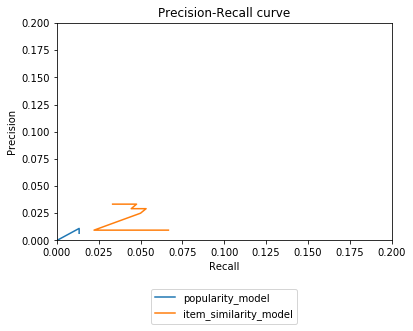

In [34]:
print("Plotting precision recall curves.")

plot_precision_recall(pm_avg_precision_list, pm_avg_recall_list, "popularity_model",
                      ism_avg_precision_list, ism_avg_recall_list, "item_similarity_model")

## 행렬분해 기반 추천 시스템

In [36]:
import math as mt
import csv
from sparsesvd import sparsesvd #행렬분해를 위해 사용됩니다.
import numpy as np
from scipy.sparse import csc_matrix #희소행렬을 위해 사용됩니다.
from scipy.sparse.linalg import * #행렬 곱셈을 위해 사용됩니다